# Exercise 1

## Part (a)

$$ dx = \text{tanh}(x) dt + d\beta $$

In [332]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [406]:
def gaussian_integral_grid(m, K, a, N):
    
    D = m.shape[0]
    
    m = np.expand_dims(m, axis=tuple(np.arange(1, D+1)))
    Kchol = np.linalg.cholesky(K)
    
    grid = np.meshgrid(*list([np.linspace(-a, a, N) for i in range(D)]))
    grid = np.stack(grid, axis=0)
    
    scaled_grid = m + np.einsum('ij, j... -> i...', Kchol, grid)
    weights = np.exp(np.sum(-0.5 * grid ** 2, axis=0))
    weights = weights * (2 * np.pi) ** - (D / 2)
    weights = weights * (2 * a / (N - 1)) ** D
    
    return scaled_grid, weights


def gaussian_integral(function, t, G, m, K, a, N, verbose=False):
    
    grid, weights = gaussian_integral_grid(m, K, a, N)
    
    grid_axes = tuple(np.arange(G))
    sum_axes = tuple(np.arange(G, len(weights.shape)+G))
    
    weights = np.expand_dims(weights, axis=grid_axes)
    if verbose:
        print(weights.shape)
    f = function(x=grid, t=t)
    integral = np.sum(f * weights, axis=sum_axes)
    
    return integral

In [407]:
def benes():
    
    def f(x, t):
        return np.tanh(x)
    
    def L(x, t):
        
        M = len(x.shape)
        I = np.eye(x.shape[0])
        I = np.expand_dims(I, axis=tuple(np.arange(2, M+1)))
        
        I = np.tile(I, (1,) + x.shape[1:])
        
        return I
    
    
    def fjac(x, t):
        
        return np.apply_along_axis(np.diag, 0, np.cosh(x) ** -2)
    
    
    def LQLT(x, t):
        
        L_ = L(x, t)
        
        return np.einsum('ij..., kj... -> ik...', L_, L_)
    
    return f, L, fjac, LQLT

In [408]:
def ode_dynamics(y, t, f, fjac, LQLT, D, a, N):
    
    m = y[:D]
    P = np.reshape(y[D:], (D, D))
    
    dm = gaussian_integral(function=f, t=t, G=1, m=m, K=P, a=a, N=N)
    
    EF = gaussian_integral(function=fjac, t=t, G=2, m=m, K=P, a=a, N=N)
    ELQLT = gaussian_integral(function=LQLT, t=t, G=2, m=m, K=P, a=a, N=N)
    
    dP = P @ EF.T + EF @ P + ELQLT
    
    dy = np.concatenate([dm, dP.reshape((-1,))], axis=0)
    
    return dy

In [409]:
f, L, fjac, LQLT = benes()

In [410]:
D = 2
m = np.ones(shape=(D,))
K = 1. * np.eye(D)
a = 3.
N = 50

gaussian_integral(L, 1., 2, m, K, a, N)

array([[0.99562421, 0.        ],
       [0.        , 0.99562421]])

In [411]:
D = 1
m0 = np.zeros(shape=(D,))
P0 = 1e-6 * np.eye(D)
a = 3.
N = 50

y0 = np.concatenate([m0, P0.reshape((-1,))], axis=0)
t = np.linspace(0., 5., 100)

f, L, fjac, LQLT = benes()

sol = odeint(ode_dynamics, y0, t, args=(f, fjac, LQLT, D, a, N))

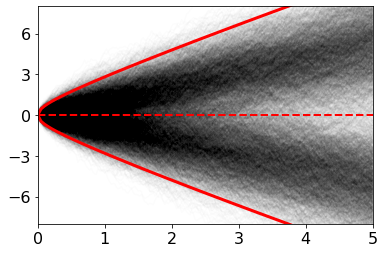

In [412]:
m = sol[:, 0]
std = sol[:, 1] ** 0.5

t_sim = np.load('../ch8/simulated_benes_t.npy')
x_sim = np.load('../ch8/simulated_benes_x.npy')

plt.plot(t, m, '--', color='red', zorder=2, linewidth=2)
plt.plot(t, m - 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t, m + 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t_sim, x_sim.T, color='k', alpha=0.01, zorder=1)
plt.xticks(np.linspace(0, 5, 6), fontsize=16)
plt.yticks(np.linspace(-6, 6, 5), fontsize=16)
plt.xlim([0, 5])
plt.ylim([-8, 8])
plt.show()

## Part (b)

In [415]:
def black_scholes(c, g):
    
    def f(x, t):
        return -c * x
    
    def L(x, t):
        return np.apply_along_axis(np.diag, 0, g * x)
    
    
    def fjac(x, t):
        return np.apply_along_axis(np.diag, 0, -c * np.ones_like(x))
    
    
    def LQLT(x, t):
        
        L_ = L(x, t)
        
        LQLT = np.einsum('ij..., kj... -> ik...', L_, L_)
        
        return LQLT
    
    return f, L, fjac, LQLT

In [420]:
def ode_dynamics(y, t, f, fjac, LQLT, D, a, N):
    
    m = y[:D]
    P = np.reshape(y[D:], (D, D))
    
    dm = gaussian_integral(function=f, t=t, G=1, m=m, K=P, a=a, N=N)
    
    EF = gaussian_integral(function=fjac, t=t, G=2, m=m, K=P, a=a, N=N)
    ELQLT = gaussian_integral(function=LQLT, t=t, G=2, m=m, K=P, a=a, N=N, verbose=True)
    
    dP = P @ EF.T + EF @ P + ELQLT
    
    dy = np.concatenate([dm, dP.reshape((-1,))], axis=0)
    
    return dy

def gaussian_integral(function, t, G, m, K, a, N, verbose=False):
    
    grid, weights = gaussian_integral_grid(m, K, a, N)
    
    grid_axes = tuple(np.arange(G))
    sum_axes = tuple(np.arange(G, len(weights.shape)+G))
    
    weights = np.expand_dims(weights, axis=grid_axes)
    f = function(x=grid, t=t)
    integral = np.sum(f * weights, axis=sum_axes)
    
    return integral

In [421]:
D = 1
m0 = np.ones(shape=(D,))
P0 = 1e-6 * np.eye(D)
a = 2.
N = 50

c = 1e-1
g = 1e-1

y0 = np.concatenate([m0, P0.reshape((-1,))], axis=0)
t = np.linspace(0., 1., 100)

f, L, fjac, LQLT = black_scholes(c, g)

sol = odeint(ode_dynamics, y0, t, args=(f, fjac, LQLT, D, a, N))

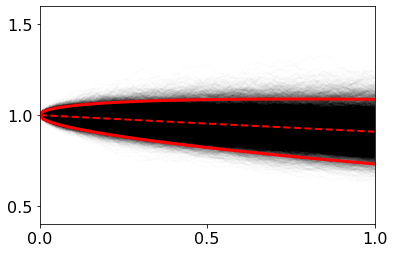

In [427]:
m = sol[:, 0]
std = sol[:, 1] ** 0.5

t_sim = np.load('../ch8/simulated_bs_t.npy')
x_sim = np.load('../ch8/simulated_bs_x.npy')

plt.plot(t, m, '--', color='red', zorder=2, linewidth=2)
plt.plot(t, m - 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t, m + 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t_sim, x_sim.T, color='k', alpha=0.01, zorder=1)
plt.xticks(np.linspace(0, 1, 3), fontsize=16)
plt.yticks(np.linspace(0.5, 1.5, 3), fontsize=16)
plt.xlim([0., 1.])
plt.ylim([0.4, 1.6])
plt.show()